In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    print(dirname)
#    for filename in filenames[:10]:
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
# /kaggle/input/histopathologic-cancer-detection/test/
#/kaggle/input/histopathologic-cancer-detection/train_labels.csv
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(df.id.unique().shape, df.shape)
df=df.set_index('id')
df.head()

(220025,) (220025, 2)


,label
id,
f38a6374c348f90b587e046aac6079959adf3835,0
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
755db6279dae599ebb4d39a9123cce439965282d,0
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
068aba587a4950175d04c680d38943fd488d6a9d,0


In [4]:
print(df.label.value_counts())
print(df.label.value_counts(normalize=True))

0    130908
1     89117
Name: label, dtype: int64
0    0.594969
1    0.405031
Name: label, dtype: float64


(96, 96)


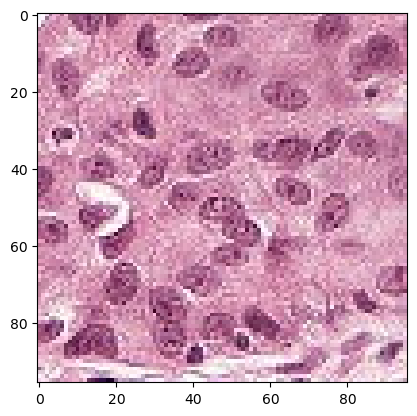

In [5]:
train_dir = '../input/histopathologic-cancer-detection/train'
training_files = os.listdir(train_dir)
with Image.open(train_dir + '/'+ training_files[0]) as im:
    print(im.size)
    plt.imshow(im)

In [6]:
df.label = df.label.astype(str)
df['file_name'] = df.index + '.tif'
df.head()

,label,file_name
id,,
f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


In [7]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)
train_ds = datagen.flow_from_dataframe(
    dataframe=df,
    directory=os.path.join('../input/histopathologic-cancer-detection/train'),
    x_col="file_name",
    y_col="label",
    subset="training",
    batch_size=32,
    seed=156,
    class_mode="binary",
    target_size=(64,64))  

Found 176020 validated image filenames belonging to 2 classes.


In [8]:
val_ds = datagen.flow_from_dataframe(
    dataframe=df,
    directory=os.path.join('../input/histopathologic-cancer-detection/train'),
    x_col="file_name",
    y_col="label",
    subset="validation",
    batch_size=32,
    seed=156,
    class_mode="binary",
    target_size=(64,64))  

Found 44005 validated image filenames belonging to 2 classes.


In [9]:
def plot_model(history):
    acc = history.history['Accuracy']
    val_acc = history.history['val_Accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(history.history['Accuracy']))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [10]:
model = Sequential()
model.add(layers.Conv2D(16,3, activation='relu', input_shape=(64,64, 3)))
model.add(layers.Conv2D(32,3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(32,3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['Accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0

Epoch 1/6
5501/5501 [==============================] - 2011s 363ms/step - loss: 0.4481 - Accuracy: 0.8019 - val_loss: 0.3962 - val_Accuracy: 0.8255
Epoch 2/6
5501/5501 [==============================] - 735s 134ms/step - loss: 0.3510 - Accuracy: 0.8489 - val_loss: 0.3973 - val_Accuracy: 0.8250
Epoch 3/6
5501/5501 [==============================] - 670s 122ms/step - loss: 0.3176 - Accuracy: 0.8650 - val_loss: 0.3283 - val_Accuracy: 0.8654
Epoch 4/6
5501/5501 [==============================] - 630s 115ms/step - loss: 0.2997 - Accuracy: 0.8740 - val_loss: 0.2919 - val_Accuracy: 0.8831
Epoch 5/6
5501/5501 [==============================] - 592s 108ms/step - loss: 0.2849 - Accuracy: 0.8814 - val_loss: 0.2879 - val_Accuracy: 0.8793
Epoch 6/6
5501/5501 [==============================] - 610s 111ms/step - loss: 0.2738 - Accuracy: 0.8857 - val_loss: 0.2819 - val_Accuracy: 0.8848


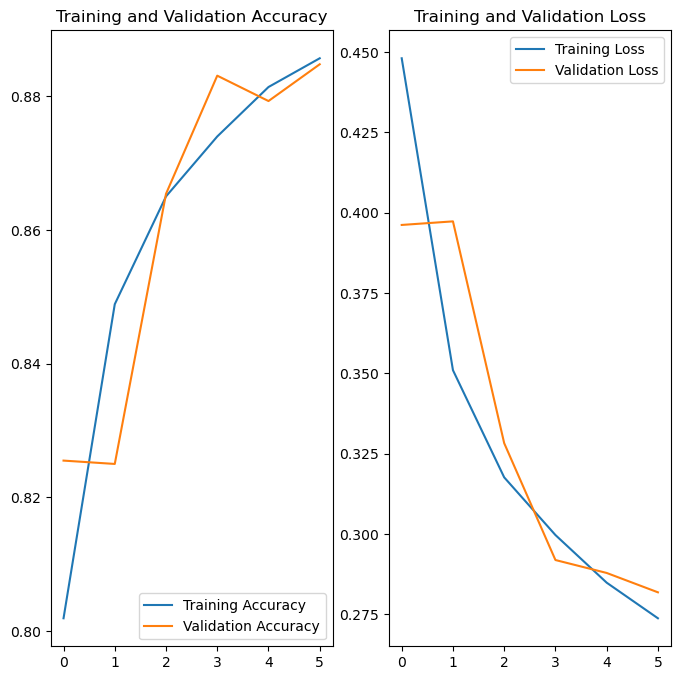

In [11]:
model_history = model.fit(train_ds, validation_data = val_ds, epochs=6, steps_per_epoch=None)
plot_model(model_history)

In [12]:
model2 = Sequential()
model2.add(layers.Conv2D(16,3, activation='relu', input_shape=(64,64, 3)))
model2.add(layers.Conv2D(16,3, activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(16,3, activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(35, activation = 'relu'))
model2.add(layers.Dense(35, activation = 'relu'))
model2.add(layers.Dense(1, activation = 'sigmoid'))

model2.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['Accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)             

Epoch 1/3
5501/5501 [==============================] - 629s 114ms/step - loss: 0.4313 - Accuracy: 0.8036 - val_loss: 0.3668 - val_Accuracy: 0.8368
Epoch 2/3
5501/5501 [==============================] - 656s 119ms/step - loss: 0.3431 - Accuracy: 0.8518 - val_loss: 0.3414 - val_Accuracy: 0.8532
Epoch 3/3
5501/5501 [==============================] - 618s 112ms/step - loss: 0.3181 - Accuracy: 0.8632 - val_loss: 0.3261 - val_Accuracy: 0.8590


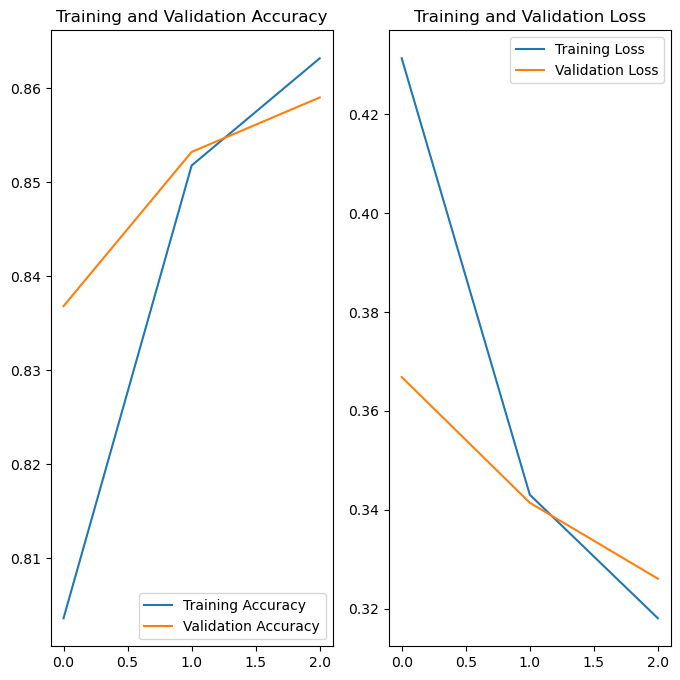

In [13]:
model2_history = model2.fit(train_ds, validation_data = val_ds, epochs=3, steps_per_epoch=None)
plot_model(model2_history)

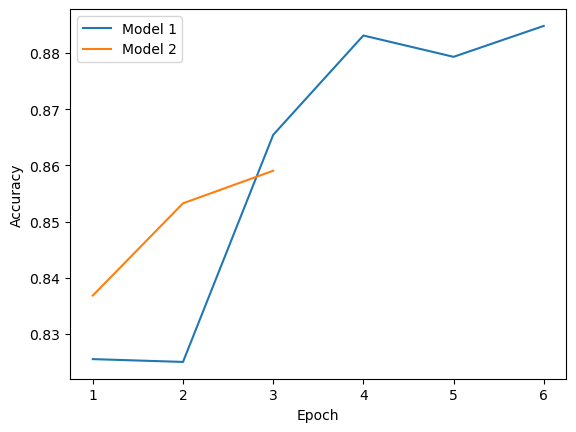

In [14]:
n = range(len(model_history.history['Accuracy']))
plt.plot(range(1,7), model_history.history['val_Accuracy'], label='Model 1')
plt.plot(range(1,4), model2_history.history['val_Accuracy'], label='Model 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()